In [1]:
# 我们应该不能选择远端的的L2正则化

In [2]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from tqdm import tqdm

import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
init_std = 0.1
init_stdv = 0.5

In [4]:

def smooth_truncation(x, R):
    # return np.exp(-(x ** 2-R**2))/(np.exp(-(x ** 2-R**2)) + 1)
    return (torch.exp(x/(0.5*R))/(torch.exp(x/(0.5*R)) + 1) - 0.5) * R * 2

In [5]:
class Net(nn.Module):
    def __init__(self, N=1000,cut_off = 20):
        super(Net, self).__init__()
        self.particle_num = N
        self.fc1 = nn.Linear(28*28, N)
        self.fc2 = nn.Linear(N, 2, bias=False)
        self.activation = nn.Sigmoid()
        nn.init.normal_(self.fc1.weight, mean=0, std=init_std)
        nn.init.normal_(self.fc1.bias, mean=0, std=init_std)
        nn.init.normal_(self.fc2.weight, mean=0, std=init_std)
        self.cut_off = cut_off

        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        
        x = self.activation(x)
        
        if self.cut_off != None:
            # self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=-self.cut_off, max=self.cut_off)
            self.fc2.weight.data = smooth_truncation(self.fc2.weight.data, R = self.cut_off )
        x = self.fc2(x)/self.particle_num 
        
        return x

class FullMomentumGradientDescentWithNoisyAndWeightDecay(torch.optim.Optimizer):
    def __init__(self, params, N, lr=1e-3, lr_2=1e-1, momentum=True, gamma=0.1, weight_decay= 0.01, noise_scale=0):
        defaults = dict(lr=lr, lr_2 = lr_2, gamma=gamma, weight_decay = weight_decay, noise_scale=noise_scale,momentum=momentum)
        self.N =  N
        super(FullMomentumGradientDescentWithNoisyAndWeightDecay, self).__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            lr_2 = group['lr_2']
            
            weight_decay = group['weight_decay']
            noise_scale = group['noise_scale']
                
            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                    
                grad = p.grad.data * self.N
                
                param_state = self.state[p]
                
                if group['momentum'] == True:
                    param_state = self.state[p]
                    
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.randn_like(p.data) * init_stdv 
                        # buf = param_state['momentum_buffer'] = torch.clone(grad).detach() 
                    
                    buf = param_state['momentum_buffer']
                    
                    if gamma != 0:
                        buf.add_(-gamma * lr_2, buf.data)
                        
                    buf.add_(-grad * lr_2)
                        
                    if weight_decay != 0:
                        buf.add_(-weight_decay * lr_2, p.data)
                            
                    if noise_scale != 0:
                        noise = torch.randn_like(p.data) * noise_scale * (lr_2 ** 1/2)
                        buf.data.add_(noise)          

                    p.data.add_(lr, buf)
                    # p.data.add_(buf)
                else:
                    if weight_decay != 0:
                        grad.add_(weight_decay , p.data)
                        
                    p.data.add_(-lr, grad)
                
                    if noise_scale != 0:
                        noise = torch.randn_like(p.data) * noise_scale * (lr ** 1/2)
                        p.data.add_(noise)
                
        return loss

In [6]:
train_dataset = datasets.MNIST('../data', train=True, download=True)
test_dataset =  datasets.MNIST('../data', train=False)


# Filter the train dataset to extract images with labels 4 and 6
train_label_4_idx = train_dataset.targets == 4
train_label_6_idx = train_dataset.targets == 6
train_selected_idx = train_label_4_idx | train_label_6_idx

train_selected_images = train_dataset.data[train_selected_idx]
train_selected_labels = train_dataset.targets[train_selected_idx]

# Relabel the train images with labels 4 as 0 and labels 6 as 1
train_selected_labels = torch.where(train_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the train set
train_dataset = TensorDataset(train_selected_images.float(), train_selected_labels)

# Filter the test dataset to extract images with labels 4 and 6
test_label_4_idx = test_dataset.targets ==4
test_label_6_idx = test_dataset.targets == 6
test_selected_idx = test_label_4_idx | test_label_6_idx

test_selected_images = test_dataset.data[test_selected_idx]
test_selected_labels = test_dataset.targets[test_selected_idx]

# Relabel the test images with labels 4 as 0 and labels 6 as 1
test_selected_labels = torch.where(test_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the test set
test_dataset = TensorDataset(test_selected_images.float(), test_selected_labels)

transform=transforms.Compose([
                       transforms.Normalize((0.1289,), (0.3053,))
                   ])

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=train_selected_images.shape[0], shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_selected_images.shape[0], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

for test_data, test_target in test_loader:
    test_data, test_target = test_data.to(device), test_target.to(device)    

In [8]:
# weight_decay = 0.001

weight_decay = 1e-4

gamma = 0.1
sigma = (2) ** (1/2) * (1e-4) ** (1/2) 

lr = 0.02
lr_2 = 0.02


particle_num = 256

cut_off = 500

momentum = True

loss_type = 'MSE'

In [9]:
if loss_type == 'MSE':
    target_onehot = torch.nn.functional.one_hot(target.long())

In [10]:
output_result = True

test_var = 'particle_num'
test_values = [128,256,512,1024,2048]

# test_var = 'lr_2'
# test_values = [0.002,0.005,0.01,0.02,0.05,0.1,0.2,1]

# test_var = 'momentum'
# test_values = [True, False]

# test_var = 'lr_2'
# test_values = [0.1]

test_time_per_objective = 10

result_trainloss_set = []
result_L2_trainloss_set = []
result_testacc_set = []

for test_value in test_values:
    globals()[test_var] = test_value
    
    trainloss_current = []
    L2_trainloss_current = []
    testacc_current = []
    
    for test_number in tqdm(range(test_time_per_objective)):
        # Define the loss function and optimizer
        net = Net(N=particle_num,cut_off=cut_off).to(device)

        if loss_type == 'MSE':
            criterion = nn.MSELoss()
        elif loss_type == 'KL':
            criterion = nn.CrossEntropyLoss()

        optimizer = FullMomentumGradientDescentWithNoisyAndWeightDecay(net.parameters(),particle_num, momentum=momentum, lr=lr,lr_2= lr_2,
                                                               weight_decay = weight_decay, noise_scale = sigma, gamma=gamma)

        # Train the network
        T = 300
        epochs = int(T//lr)
        
        # epochs = 10000
        
        train_losses = []
        test_accs = []
        L2_train_losses = []
        
        for epoch in range(1, epochs + 1):
#             for param_group in optimizer.param_groups:
#                 param_group['lr_2'] = 1
            
            train_loss = 0.0
            net.train()

            optimizer.zero_grad()
            output = net(data)
            if loss_type == 'MSE':
                loss = criterion(output, target_onehot.float())/2
            elif loss_type == 'KL':
                loss = criterion(output, target)/2

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            squared_sum = 0
#             l2_norm = torch.zeros(particle_num).cuda()
            
#             for p_idx, p in enumerate(net.parameters()):
#                 if p_idx == 0:
#                     l2_norm +=  (p.data **2).sum(axis=1)
#                 elif p_idx == 2:
#                     l2_norm +=  (p.data **2).sum(axis=0)
#                 else: 
#                     l2_norm +=  (p.data **2)
                    
#             reg_array = (l2_norm > C).long()
            
#             for idx, param in enumerate(net.parameters()):
#                 if idx == 2:  # 存疑
#                     data_temp = torch.clamp(param.data, min=-cut_off,max=cut_off)
#                     squared_sum += torch.sum((data_temp * reg_array) ** 2) / particle_num
#                 elif idx == 1:
#                     squared_sum += torch.sum((param.data * reg_array) ** 2) / particle_num
#                 elif idx == 0:
#                     squared_sum += torch.sum((param.data * reg_array.view(particle_num,1)) ** 2) / particle_num
                    
            L2_trian_loss = train_loss + squared_sum * weight_decay * 0

            velo_squared_sum = 0
            for group in optimizer.param_groups:
                for p in group['params']:
                    param_state = optimizer.state[p]
                    velo_squared_sum += torch.sum(param_state['momentum_buffer'] ** 2) / particle_num
            
            L2_trian_loss += gamma/2 * velo_squared_sum.item()
            
            L2_train_losses.append(L2_trian_loss)

            net.eval()
            correct = 0
#             with torch.no_grad():
#                 output = net(test_data)
#                 _, predicted = torch.max(output.data, 1)
#                 correct += (predicted == test_target).sum().item()

            test_acc = correct / len(test_loader.dataset)
            test_accs.append(test_acc)
            if (epoch == 1 or epoch % 1000 == 0) and output_result:
                
                print('T: {:.3f} Train Loss: {:.6f} L2-Train Loss: {:.6f} Test Accuracy: {:.2f}%'.format(
                    epoch * lr, train_loss, L2_trian_loss, 100. * test_acc))
                
                squared_sum = 0
            
                for idx, param in enumerate(net.parameters()):
                    squared_sum += torch.sum(param.grad.data ** 2)
                        
                print('grad_l2_norm = ',squared_sum)
                
        trainloss_current.append(train_losses)
        L2_trainloss_current.append(L2_train_losses)
        testacc_current.append(test_accs)

    result_trainloss_set.append(trainloss_current)
    result_L2_trainloss_set.append(L2_trainloss_current)
    result_testacc_set.append(testacc_current)
    
    avg_trainloss_cur = np.mean(np.array(trainloss_current)[:,-500:])
    avg_L2_trainloss =  np.mean(np.array(L2_trainloss_current)[:,-500:])
    
    print('Finish test %s=%.4f'%(test_var,globals()[test_var]),
          'cutoff = %.2f'%(cut_off),
           'lr = %.3f'%(lr),
           'lr2 = %.3f'%(lr_2),
          'momentum = %.2f'%(momentum),
          'avg_trainloss=%.3e'%(avg_trainloss_cur), 
          'avg_L2_trainloss=%.3e'%(avg_L2_trainloss))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\alexn\AppData\Local\Temp\ipykernel_8384\2775359686.py:63: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)
  buf.add_(-gamma * lr_2, buf.data)


T: 0.020 Train Loss: 0.248814 L2-Train Loss: 10.057047 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0004, device='cuda:0')
T: 20.000 Train Loss: 0.025160 L2-Train Loss: 0.192231 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3938e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018279 L2-Train Loss: 0.019495 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.7173e-06, device='cuda:0')
T: 60.000 Train Loss: 0.014475 L2-Train Loss: 0.015251 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3910e-06, device='cuda:0')
T: 80.000 Train Loss: 0.012877 L2-Train Loss: 0.013939 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3111e-06, device='cuda:0')
T: 100.000 Train Loss: 0.012076 L2-Train Loss: 0.013143 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9636e-06, device='cuda:0')
T: 120.000 Train Loss: 0.011500 L2-Train Loss: 0.012540 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.5942e-07, device='cuda:0')
T: 140.000 Train Loss: 0.011057 L2-Train Loss: 0.012062 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3468

 10%|████████▎                                                                          | 1/10 [00:42<06:18, 42.06s/it]

T: 0.020 Train Loss: 0.251960 L2-Train Loss: 10.129167 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0005, device='cuda:0')
T: 20.000 Train Loss: 0.029585 L2-Train Loss: 0.197316 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2881e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018733 L2-Train Loss: 0.020017 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.7294e-06, device='cuda:0')
T: 60.000 Train Loss: 0.015321 L2-Train Loss: 0.016093 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.8755e-06, device='cuda:0')
T: 80.000 Train Loss: 0.013732 L2-Train Loss: 0.014786 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1905e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013010 L2-Train Loss: 0.014078 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.3591e-07, device='cuda:0')
T: 120.000 Train Loss: 0.012496 L2-Train Loss: 0.013534 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.4338e-07, device='cuda:0')
T: 140.000 Train Loss: 0.012145 L2-Train Loss: 0.013144 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.0515

 20%|████████████████▌                                                                  | 2/10 [01:21<05:26, 40.77s/it]

T: 0.020 Train Loss: 0.249712 L2-Train Loss: 10.045377 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0004, device='cuda:0')
T: 20.000 Train Loss: 0.035320 L2-Train Loss: 0.200838 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1971e-05, device='cuda:0')
T: 40.000 Train Loss: 0.017183 L2-Train Loss: 0.018510 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.7504e-06, device='cuda:0')
T: 60.000 Train Loss: 0.014929 L2-Train Loss: 0.015702 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0327e-06, device='cuda:0')
T: 80.000 Train Loss: 0.013109 L2-Train Loss: 0.014169 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.1019e-06, device='cuda:0')
T: 100.000 Train Loss: 0.012349 L2-Train Loss: 0.013413 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0945e-06, device='cuda:0')
T: 120.000 Train Loss: 0.011783 L2-Train Loss: 0.012820 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.9121e-06, device='cuda:0')
T: 140.000 Train Loss: 0.011334 L2-Train Loss: 0.012336 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.3062

 30%|████████████████████████▉                                                          | 3/10 [02:01<04:41, 40.15s/it]

T: 0.020 Train Loss: 0.254486 L2-Train Loss: 10.053520 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0005, device='cuda:0')
T: 20.000 Train Loss: 0.031304 L2-Train Loss: 0.197990 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7665e-05, device='cuda:0')
T: 40.000 Train Loss: 0.020857 L2-Train Loss: 0.022125 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0886e-05, device='cuda:0')
T: 60.000 Train Loss: 0.016270 L2-Train Loss: 0.017053 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1227e-06, device='cuda:0')
T: 80.000 Train Loss: 0.014477 L2-Train Loss: 0.015533 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1489e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013542 L2-Train Loss: 0.014607 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.8754e-07, device='cuda:0')
T: 120.000 Train Loss: 0.012848 L2-Train Loss: 0.013886 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0048e-06, device='cuda:0')
T: 140.000 Train Loss: 0.012370 L2-Train Loss: 0.013370 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4800

 40%|█████████████████████████████████▏                                                 | 4/10 [02:40<03:59, 39.93s/it]

T: 0.020 Train Loss: 0.248285 L2-Train Loss: 9.967959 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0004, device='cuda:0')
T: 20.000 Train Loss: 0.035877 L2-Train Loss: 0.200498 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6055e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018368 L2-Train Loss: 0.019733 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.8205e-06, device='cuda:0')
T: 60.000 Train Loss: 0.015701 L2-Train Loss: 0.016473 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.8732e-06, device='cuda:0')
T: 80.000 Train Loss: 0.013770 L2-Train Loss: 0.014820 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4685e-06, device='cuda:0')
T: 100.000 Train Loss: 0.012964 L2-Train Loss: 0.014019 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3852e-06, device='cuda:0')
T: 120.000 Train Loss: 0.012409 L2-Train Loss: 0.013436 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.9669e-07, device='cuda:0')
T: 140.000 Train Loss: 0.011995 L2-Train Loss: 0.012984 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.0208e

 50%|█████████████████████████████████████████▌                                         | 5/10 [03:20<03:19, 39.95s/it]

T: 0.020 Train Loss: 0.250110 L2-Train Loss: 10.043100 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0005, device='cuda:0')
T: 20.000 Train Loss: 0.026252 L2-Train Loss: 0.193136 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8614e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018426 L2-Train Loss: 0.019666 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.8655e-06, device='cuda:0')
T: 60.000 Train Loss: 0.014481 L2-Train Loss: 0.015253 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.1645e-06, device='cuda:0')
T: 80.000 Train Loss: 0.012963 L2-Train Loss: 0.014012 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2359e-06, device='cuda:0')
T: 100.000 Train Loss: 0.012206 L2-Train Loss: 0.013265 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0699e-06, device='cuda:0')
T: 120.000 Train Loss: 0.011644 L2-Train Loss: 0.012679 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6698e-06, device='cuda:0')
T: 140.000 Train Loss: 0.011169 L2-Train Loss: 0.012170 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.9023

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:00<02:39, 39.90s/it]

T: 0.020 Train Loss: 0.248629 L2-Train Loss: 10.022617 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0005, device='cuda:0')
T: 20.000 Train Loss: 0.037444 L2-Train Loss: 0.202618 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2175e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018643 L2-Train Loss: 0.020005 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.9000e-06, device='cuda:0')
T: 60.000 Train Loss: 0.016118 L2-Train Loss: 0.016892 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.0577e-06, device='cuda:0')
T: 80.000 Train Loss: 0.014222 L2-Train Loss: 0.015275 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0447e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013317 L2-Train Loss: 0.014380 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0138e-06, device='cuda:0')
T: 120.000 Train Loss: 0.012701 L2-Train Loss: 0.013733 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.2644e-07, device='cuda:0')
T: 140.000 Train Loss: 0.012242 L2-Train Loss: 0.013240 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.4351

 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:40<01:59, 39.96s/it]

T: 0.020 Train Loss: 0.249712 L2-Train Loss: 10.097974 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0004, device='cuda:0')
T: 20.000 Train Loss: 0.033937 L2-Train Loss: 0.200802 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6218e-05, device='cuda:0')
T: 40.000 Train Loss: 0.018930 L2-Train Loss: 0.020295 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.6472e-06, device='cuda:0')
T: 60.000 Train Loss: 0.015830 L2-Train Loss: 0.016608 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6171e-06, device='cuda:0')
T: 80.000 Train Loss: 0.014070 L2-Train Loss: 0.015130 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3494e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013324 L2-Train Loss: 0.014391 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6771e-06, device='cuda:0')
T: 120.000 Train Loss: 0.012756 L2-Train Loss: 0.013799 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3450e-06, device='cuda:0')
T: 140.000 Train Loss: 0.012308 L2-Train Loss: 0.013314 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.1899

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:20<01:19, 39.87s/it]

T: 0.020 Train Loss: 0.248423 L2-Train Loss: 10.046274 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0005, device='cuda:0')
T: 20.000 Train Loss: 0.037794 L2-Train Loss: 0.204389 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6527e-05, device='cuda:0')
T: 40.000 Train Loss: 0.019767 L2-Train Loss: 0.021202 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.6992e-06, device='cuda:0')
T: 60.000 Train Loss: 0.016463 L2-Train Loss: 0.017231 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0229e-06, device='cuda:0')
T: 80.000 Train Loss: 0.014356 L2-Train Loss: 0.015419 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.5625e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013484 L2-Train Loss: 0.014547 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2731e-06, device='cuda:0')
T: 120.000 Train Loss: 0.012878 L2-Train Loss: 0.013912 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3567e-06, device='cuda:0')
T: 140.000 Train Loss: 0.012387 L2-Train Loss: 0.013387 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1141

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:00<00:39, 39.88s/it]

T: 0.020 Train Loss: 0.251183 L2-Train Loss: 10.030891 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0004, device='cuda:0')
T: 20.000 Train Loss: 0.031219 L2-Train Loss: 0.197452 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4753e-05, device='cuda:0')
T: 40.000 Train Loss: 0.019160 L2-Train Loss: 0.020489 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.6449e-06, device='cuda:0')
T: 60.000 Train Loss: 0.015777 L2-Train Loss: 0.016545 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.7517e-06, device='cuda:0')
T: 80.000 Train Loss: 0.013901 L2-Train Loss: 0.014960 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4825e-06, device='cuda:0')
T: 100.000 Train Loss: 0.013012 L2-Train Loss: 0.014072 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.7311e-07, device='cuda:0')
T: 120.000 Train Loss: 0.012436 L2-Train Loss: 0.013466 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.9851e-07, device='cuda:0')
T: 140.000 Train Loss: 0.011994 L2-Train Loss: 0.012994 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.6799

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:40<00:00, 40.01s/it]


Finish test particle_num=128.0000 cutoff = 500.00 lr = 0.020 lr2 = 0.020 momentum = 1.00 avg_trainloss=1.026e-02 avg_L2_trainloss=1.104e-02


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

T: 0.020 Train Loss: 0.250406 L2-Train Loss: 10.068796 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.029846 L2-Train Loss: 0.196107 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8767e-05, device='cuda:0')
T: 40.000 Train Loss: 0.015215 L2-Train Loss: 0.016525 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.7836e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012868 L2-Train Loss: 0.013629 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4709e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011393 L2-Train Loss: 0.012445 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.7114e-07, device='cuda:0')
T: 100.000 Train Loss: 0.010699 L2-Train Loss: 0.011765 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.0058e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010225 L2-Train Loss: 0.011257 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.8294e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009893 L2-Train Loss: 0.010892 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.7012

 10%|████████▎                                                                          | 1/10 [00:46<06:57, 46.35s/it]

T: 0.020 Train Loss: 0.249624 L2-Train Loss: 10.086623 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.029915 L2-Train Loss: 0.196646 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.5461e-05, device='cuda:0')
T: 40.000 Train Loss: 0.014145 L2-Train Loss: 0.015503 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.8099e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012549 L2-Train Loss: 0.013308 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.6708e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011057 L2-Train Loss: 0.012107 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.4852e-07, device='cuda:0')
T: 100.000 Train Loss: 0.010513 L2-Train Loss: 0.011570 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6794e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010100 L2-Train Loss: 0.011131 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.3694e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009792 L2-Train Loss: 0.010790 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7432

 20%|████████████████▌                                                                  | 2/10 [01:33<06:12, 46.62s/it]

T: 0.020 Train Loss: 0.250286 L2-Train Loss: 10.056957 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.030315 L2-Train Loss: 0.196700 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8403e-05, device='cuda:0')
T: 40.000 Train Loss: 0.015378 L2-Train Loss: 0.016740 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.3465e-06, device='cuda:0')
T: 60.000 Train Loss: 0.013335 L2-Train Loss: 0.014096 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4405e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011707 L2-Train Loss: 0.012763 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1161e-07, device='cuda:0')
T: 100.000 Train Loss: 0.011029 L2-Train Loss: 0.012089 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3643e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010566 L2-Train Loss: 0.011597 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4188e-07, device='cuda:0')
T: 140.000 Train Loss: 0.010210 L2-Train Loss: 0.011211 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3470

 30%|████████████████████████▉                                                          | 3/10 [02:19<05:26, 46.61s/it]

T: 0.020 Train Loss: 0.249405 L2-Train Loss: 10.030598 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.033537 L2-Train Loss: 0.199121 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.6507e-05, device='cuda:0')
T: 40.000 Train Loss: 0.014882 L2-Train Loss: 0.016247 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.7415e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012909 L2-Train Loss: 0.013684 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8329e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011408 L2-Train Loss: 0.012455 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3985e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010776 L2-Train Loss: 0.011833 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.3136e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010338 L2-Train Loss: 0.011365 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4283e-07, device='cuda:0')
T: 140.000 Train Loss: 0.010010 L2-Train Loss: 0.011006 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4358

 40%|█████████████████████████████████▏                                                 | 4/10 [03:06<04:40, 46.69s/it]

T: 0.020 Train Loss: 0.247084 L2-Train Loss: 10.130890 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.030570 L2-Train Loss: 0.198058 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4198e-05, device='cuda:0')
T: 40.000 Train Loss: 0.014688 L2-Train Loss: 0.016027 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4553e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012808 L2-Train Loss: 0.013566 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9348e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011396 L2-Train Loss: 0.012454 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4718e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010807 L2-Train Loss: 0.011874 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.1301e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010413 L2-Train Loss: 0.011452 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.8932e-07, device='cuda:0')
T: 140.000 Train Loss: 0.010108 L2-Train Loss: 0.011109 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1965

 50%|█████████████████████████████████████████▌                                         | 5/10 [03:53<03:53, 46.72s/it]

T: 0.020 Train Loss: 0.250090 L2-Train Loss: 10.101827 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.022867 L2-Train Loss: 0.190474 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.2465e-06, device='cuda:0')
T: 40.000 Train Loss: 0.015373 L2-Train Loss: 0.016618 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5740e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012253 L2-Train Loss: 0.013022 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3422e-06, device='cuda:0')
T: 80.000 Train Loss: 0.010929 L2-Train Loss: 0.011981 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2288e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010357 L2-Train Loss: 0.011420 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.5285e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009945 L2-Train Loss: 0.010976 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4138e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009617 L2-Train Loss: 0.010618 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6075

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:39<03:06, 46.66s/it]

T: 0.020 Train Loss: 0.247266 L2-Train Loss: 10.010980 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.029480 L2-Train Loss: 0.195122 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6665e-05, device='cuda:0')
T: 40.000 Train Loss: 0.015351 L2-Train Loss: 0.016659 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.3008e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012582 L2-Train Loss: 0.013342 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4405e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011301 L2-Train Loss: 0.012342 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8439e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010748 L2-Train Loss: 0.011802 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.3901e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010335 L2-Train Loss: 0.011357 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.4233e-07, device='cuda:0')
T: 140.000 Train Loss: 0.010040 L2-Train Loss: 0.011030 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.3895

 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:26<02:19, 46.63s/it]

T: 0.020 Train Loss: 0.250561 L2-Train Loss: 10.100921 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.029557 L2-Train Loss: 0.196604 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8038e-05, device='cuda:0')
T: 40.000 Train Loss: 0.014991 L2-Train Loss: 0.016320 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0475e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012699 L2-Train Loss: 0.013460 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5385e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011337 L2-Train Loss: 0.012394 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.6735e-07, device='cuda:0')
T: 100.000 Train Loss: 0.010686 L2-Train Loss: 0.011752 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.9457e-07, device='cuda:0')
T: 120.000 Train Loss: 0.010271 L2-Train Loss: 0.011307 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.1473e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009902 L2-Train Loss: 0.010904 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5087

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:12<01:33, 46.56s/it]

T: 0.020 Train Loss: 0.246824 L2-Train Loss: 10.080179 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.024219 L2-Train Loss: 0.191535 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3233e-05, device='cuda:0')
T: 40.000 Train Loss: 0.015053 L2-Train Loss: 0.016319 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2390e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011995 L2-Train Loss: 0.012763 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3292e-06, device='cuda:0')
T: 80.000 Train Loss: 0.010757 L2-Train Loss: 0.011805 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4442e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010228 L2-Train Loss: 0.011287 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.4612e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009819 L2-Train Loss: 0.010851 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1532e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009509 L2-Train Loss: 0.010510 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7252

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:59<00:46, 46.55s/it]

T: 0.020 Train Loss: 0.248244 L2-Train Loss: 10.040898 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 20.000 Train Loss: 0.029023 L2-Train Loss: 0.195181 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7301e-05, device='cuda:0')
T: 40.000 Train Loss: 0.014968 L2-Train Loss: 0.016307 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.7940e-06, device='cuda:0')
T: 60.000 Train Loss: 0.012697 L2-Train Loss: 0.013467 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3225e-06, device='cuda:0')
T: 80.000 Train Loss: 0.011124 L2-Train Loss: 0.012179 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3587e-06, device='cuda:0')
T: 100.000 Train Loss: 0.010469 L2-Train Loss: 0.011531 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2823e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009968 L2-Train Loss: 0.011000 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.5984e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009649 L2-Train Loss: 0.010645 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9167

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:45<00:00, 46.59s/it]


Finish test particle_num=256.0000 cutoff = 500.00 lr = 0.020 lr2 = 0.020 momentum = 1.00 avg_trainloss=8.504e-03 avg_L2_trainloss=9.285e-03


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

T: 0.020 Train Loss: 0.250361 L2-Train Loss: 10.048106 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.024137 L2-Train Loss: 0.190393 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.0591e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012964 L2-Train Loss: 0.014243 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7620e-06, device='cuda:0')
T: 60.000 Train Loss: 0.010887 L2-Train Loss: 0.011644 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.2643e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009784 L2-Train Loss: 0.010829 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2483e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009304 L2-Train Loss: 0.010361 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9032e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008958 L2-Train Loss: 0.009986 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1747e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008687 L2-Train Loss: 0.009682 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5285

 10%|████████▎                                                                          | 1/10 [01:17<11:39, 77.67s/it]

T: 0.020 Train Loss: 0.249897 L2-Train Loss: 9.997134 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.024975 L2-Train Loss: 0.190344 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.0592e-06, device='cuda:0')
T: 40.000 Train Loss: 0.013269 L2-Train Loss: 0.014553 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8075e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011168 L2-Train Loss: 0.011923 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5288e-06, device='cuda:0')
T: 80.000 Train Loss: 0.009940 L2-Train Loss: 0.010985 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2327e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009427 L2-Train Loss: 0.010483 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3985e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009048 L2-Train Loss: 0.010075 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.0329e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008757 L2-Train Loss: 0.009749 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1125e

 20%|████████████████▌                                                                  | 2/10 [02:35<10:21, 77.65s/it]

T: 0.020 Train Loss: 0.249441 L2-Train Loss: 10.061451 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.027849 L2-Train Loss: 0.194119 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0360e-05, device='cuda:0')
T: 40.000 Train Loss: 0.013105 L2-Train Loss: 0.014444 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.0025e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011443 L2-Train Loss: 0.012199 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.2398e-07, device='cuda:0')
T: 80.000 Train Loss: 0.010128 L2-Train Loss: 0.011177 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.5173e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009639 L2-Train Loss: 0.010697 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3812e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009243 L2-Train Loss: 0.010274 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1848e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008961 L2-Train Loss: 0.009956 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5239

 30%|████████████████████████▉                                                          | 3/10 [03:53<09:04, 77.72s/it]

T: 0.020 Train Loss: 0.250278 L2-Train Loss: 10.052007 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.028969 L2-Train Loss: 0.195267 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0522e-05, device='cuda:0')
T: 40.000 Train Loss: 0.012965 L2-Train Loss: 0.014320 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7085e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011501 L2-Train Loss: 0.012258 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.3000e-07, device='cuda:0')
T: 80.000 Train Loss: 0.010100 L2-Train Loss: 0.011153 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.0645e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009587 L2-Train Loss: 0.010646 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8249e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009204 L2-Train Loss: 0.010235 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6146e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008914 L2-Train Loss: 0.009909 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0635

 40%|█████████████████████████████████▏                                                 | 4/10 [05:10<07:46, 77.75s/it]

T: 0.020 Train Loss: 0.250195 L2-Train Loss: 10.031583 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.027882 L2-Train Loss: 0.193581 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.9273e-06, device='cuda:0')
T: 40.000 Train Loss: 0.014128 L2-Train Loss: 0.015432 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6909e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011693 L2-Train Loss: 0.012454 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.9451e-07, device='cuda:0')
T: 80.000 Train Loss: 0.010450 L2-Train Loss: 0.011494 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7792e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009906 L2-Train Loss: 0.010963 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6424e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009496 L2-Train Loss: 0.010525 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9671e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009187 L2-Train Loss: 0.010182 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4322

 50%|█████████████████████████████████████████▌                                         | 5/10 [06:28<06:29, 77.82s/it]

T: 0.020 Train Loss: 0.251761 L2-Train Loss: 10.059016 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.026126 L2-Train Loss: 0.192617 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.6631e-06, device='cuda:0')
T: 40.000 Train Loss: 0.013870 L2-Train Loss: 0.015177 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1498e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011562 L2-Train Loss: 0.012321 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.7382e-07, device='cuda:0')
T: 80.000 Train Loss: 0.010312 L2-Train Loss: 0.011361 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7821e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009756 L2-Train Loss: 0.010816 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.9559e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009353 L2-Train Loss: 0.010386 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8097e-07, device='cuda:0')
T: 140.000 Train Loss: 0.009027 L2-Train Loss: 0.010026 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2939

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:46<05:11, 77.86s/it]

T: 0.020 Train Loss: 0.250041 L2-Train Loss: 10.064849 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.027760 L2-Train Loss: 0.194318 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0388e-05, device='cuda:0')
T: 40.000 Train Loss: 0.012595 L2-Train Loss: 0.013955 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9522e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011187 L2-Train Loss: 0.011941 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.9224e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009859 L2-Train Loss: 0.010910 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.0966e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009397 L2-Train Loss: 0.010457 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.7647e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009056 L2-Train Loss: 0.010087 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6375e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008766 L2-Train Loss: 0.009761 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6680

 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:04<03:53, 77.88s/it]

T: 0.020 Train Loss: 0.250812 L2-Train Loss: 10.021303 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.024044 L2-Train Loss: 0.190207 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.8789e-06, device='cuda:0')
T: 40.000 Train Loss: 0.014496 L2-Train Loss: 0.015771 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7726e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011599 L2-Train Loss: 0.012370 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.2515e-07, device='cuda:0')
T: 80.000 Train Loss: 0.010201 L2-Train Loss: 0.011256 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.8015e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009585 L2-Train Loss: 0.010647 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3354e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009116 L2-Train Loss: 0.010150 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4668e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008775 L2-Train Loss: 0.009772 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5332

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:22<02:35, 77.88s/it]

T: 0.020 Train Loss: 0.250736 L2-Train Loss: 10.012012 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.024505 L2-Train Loss: 0.190301 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.1188e-06, device='cuda:0')
T: 40.000 Train Loss: 0.013626 L2-Train Loss: 0.014917 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6458e-06, device='cuda:0')
T: 60.000 Train Loss: 0.011333 L2-Train Loss: 0.012094 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1264e-06, device='cuda:0')
T: 80.000 Train Loss: 0.010045 L2-Train Loss: 0.011093 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.2437e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009471 L2-Train Loss: 0.010529 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5509e-07, device='cuda:0')
T: 120.000 Train Loss: 0.009077 L2-Train Loss: 0.010106 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6833e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008773 L2-Train Loss: 0.009766 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.2950

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [11:40<01:17, 77.84s/it]

T: 0.020 Train Loss: 0.249984 L2-Train Loss: 10.030788 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0001, device='cuda:0')
T: 20.000 Train Loss: 0.027681 L2-Train Loss: 0.193333 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0216e-05, device='cuda:0')
T: 40.000 Train Loss: 0.012709 L2-Train Loss: 0.014032 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8079e-06, device='cuda:0')
T: 60.000 Train Loss: 0.010953 L2-Train Loss: 0.011711 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.6260e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009748 L2-Train Loss: 0.010791 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4936e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009280 L2-Train Loss: 0.010334 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8709e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008931 L2-Train Loss: 0.009959 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4196e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008671 L2-Train Loss: 0.009663 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7159

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:58<00:00, 77.80s/it]


Finish test particle_num=512.0000 cutoff = 500.00 lr = 0.020 lr2 = 0.020 momentum = 1.00 avg_trainloss=7.583e-03 avg_L2_trainloss=8.362e-03


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

T: 0.020 Train Loss: 0.250127 L2-Train Loss: 10.065819 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3307e-05, device='cuda:0')
T: 20.000 Train Loss: 0.022870 L2-Train Loss: 0.189661 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.4653e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012678 L2-Train Loss: 0.013945 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.7153e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010213 L2-Train Loss: 0.010976 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.9079e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009153 L2-Train Loss: 0.010200 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1560e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008691 L2-Train Loss: 0.009754 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.9877e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008351 L2-Train Loss: 0.009382 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.5864e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008093 L2-Train Loss: 0.009090 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.

 10%|████████▏                                                                         | 1/10 [02:20<21:08, 140.92s/it]

T: 0.020 Train Loss: 0.249968 L2-Train Loss: 10.042044 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3443e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025906 L2-Train Loss: 0.191996 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6874e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012279 L2-Train Loss: 0.013609 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.5249e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010688 L2-Train Loss: 0.011444 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.9066e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009424 L2-Train Loss: 0.010472 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9442e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008951 L2-Train Loss: 0.010009 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2483e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008594 L2-Train Loss: 0.009625 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.3932e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008321 L2-Train Loss: 0.009318 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.

 20%|████████████████▍                                                                 | 2/10 [04:41<18:47, 140.95s/it]

T: 0.020 Train Loss: 0.249816 L2-Train Loss: 10.045958 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3538e-05, device='cuda:0')
T: 20.000 Train Loss: 0.027818 L2-Train Loss: 0.193777 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.4943e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011950 L2-Train Loss: 0.013291 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.0451e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010620 L2-Train Loss: 0.011371 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2498e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009400 L2-Train Loss: 0.010445 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4224e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008971 L2-Train Loss: 0.010027 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2639e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008638 L2-Train Loss: 0.009668 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.7815e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008370 L2-Train Loss: 0.009365 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.

 30%|████████████████████████▌                                                         | 3/10 [07:03<16:27, 141.09s/it]

T: 0.020 Train Loss: 0.250774 L2-Train Loss: 10.059212 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3976e-05, device='cuda:0')
T: 20.000 Train Loss: 0.023136 L2-Train Loss: 0.189774 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6608e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012812 L2-Train Loss: 0.014105 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.0547e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010609 L2-Train Loss: 0.011373 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0076e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009435 L2-Train Loss: 0.010484 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3977e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008941 L2-Train Loss: 0.010000 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.8307e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008572 L2-Train Loss: 0.009602 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2944e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008288 L2-Train Loss: 0.009286 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.

 40%|████████████████████████████████▊                                                 | 4/10 [09:24<14:06, 141.15s/it]

T: 0.020 Train Loss: 0.250743 L2-Train Loss: 10.046811 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.6296e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025111 L2-Train Loss: 0.191247 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.2802e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012078 L2-Train Loss: 0.013394 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.1751e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010407 L2-Train Loss: 0.011165 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6858e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009215 L2-Train Loss: 0.010260 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1189e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008746 L2-Train Loss: 0.009806 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4098e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008404 L2-Train Loss: 0.009433 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.4087e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008123 L2-Train Loss: 0.009118 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.

 50%|█████████████████████████████████████████                                         | 5/10 [11:45<11:46, 141.26s/it]

T: 0.020 Train Loss: 0.251212 L2-Train Loss: 10.063978 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.6598e-05, device='cuda:0')
T: 20.000 Train Loss: 0.023430 L2-Train Loss: 0.190166 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5587e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012992 L2-Train Loss: 0.014263 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0635e-06, device='cuda:0')
T: 60.000 Train Loss: 0.010480 L2-Train Loss: 0.011244 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2123e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009383 L2-Train Loss: 0.010430 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.5296e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008892 L2-Train Loss: 0.009954 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1369e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008530 L2-Train Loss: 0.009562 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.5823e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008266 L2-Train Loss: 0.009261 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.

 60%|█████████████████████████████████████████████████▏                                | 6/10 [14:07<09:25, 141.30s/it]

T: 0.020 Train Loss: 0.250200 L2-Train Loss: 10.056700 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2628e-05, device='cuda:0')
T: 20.000 Train Loss: 0.026070 L2-Train Loss: 0.192592 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.4051e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012538 L2-Train Loss: 0.013878 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.2551e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010954 L2-Train Loss: 0.011708 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0806e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009613 L2-Train Loss: 0.010666 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.8312e-07, device='cuda:0')
T: 100.000 Train Loss: 0.009086 L2-Train Loss: 0.010148 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.0142e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008714 L2-Train Loss: 0.009747 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.3482e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008414 L2-Train Loss: 0.009413 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [16:28<07:04, 141.36s/it]

T: 0.020 Train Loss: 0.249022 L2-Train Loss: 10.072867 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.3826e-05, device='cuda:0')
T: 20.000 Train Loss: 0.024956 L2-Train Loss: 0.191609 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.5078e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012024 L2-Train Loss: 0.013344 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.3692e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010444 L2-Train Loss: 0.011197 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.8960e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009249 L2-Train Loss: 0.010300 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4205e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008802 L2-Train Loss: 0.009865 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0905e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008471 L2-Train Loss: 0.009503 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.4719e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008202 L2-Train Loss: 0.009200 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [18:50<04:42, 141.37s/it]

T: 0.020 Train Loss: 0.250658 L2-Train Loss: 10.047629 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.4386e-05, device='cuda:0')
T: 20.000 Train Loss: 0.023821 L2-Train Loss: 0.190094 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5285e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012648 L2-Train Loss: 0.013931 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0174e-06, device='cuda:0')
T: 60.000 Train Loss: 0.010448 L2-Train Loss: 0.011209 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.9395e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009313 L2-Train Loss: 0.010361 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.6284e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008820 L2-Train Loss: 0.009878 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2174e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008464 L2-Train Loss: 0.009492 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.6622e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008191 L2-Train Loss: 0.009187 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [21:11<02:21, 141.32s/it]

T: 0.020 Train Loss: 0.250166 L2-Train Loss: 10.026942 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.4480e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025472 L2-Train Loss: 0.191334 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7878e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012016 L2-Train Loss: 0.013347 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.2194e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010625 L2-Train Loss: 0.011379 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.5758e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009360 L2-Train Loss: 0.010407 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.7305e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008884 L2-Train Loss: 0.009942 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.4138e-07, device='cuda:0')
T: 120.000 Train Loss: 0.008520 L2-Train Loss: 0.009548 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2873e-07, device='cuda:0')
T: 140.000 Train Loss: 0.008230 L2-Train Loss: 0.009225 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:32<00:00, 141.23s/it]


Finish test particle_num=1024.0000 cutoff = 500.00 lr = 0.020 lr2 = 0.020 momentum = 1.00 avg_trainloss=7.031e-03 avg_L2_trainloss=7.811e-03


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

T: 0.020 Train Loss: 0.250187 L2-Train Loss: 10.032302 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.8007e-05, device='cuda:0')
T: 20.000 Train Loss: 0.024347 L2-Train Loss: 0.190395 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.0670e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011921 L2-Train Loss: 0.013236 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.9467e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010196 L2-Train Loss: 0.010950 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9006e-07, device='cuda:0')
T: 80.000 Train Loss: 0.008999 L2-Train Loss: 0.010046 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.5011e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008548 L2-Train Loss: 0.009605 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.5113e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008212 L2-Train Loss: 0.009241 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.4433e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007941 L2-Train Loss: 0.008935 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

 10%|████████▏                                                                         | 1/10 [04:39<41:58, 279.82s/it]

T: 0.020 Train Loss: 0.250065 L2-Train Loss: 10.046188 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7618e-05, device='cuda:0')
T: 20.000 Train Loss: 0.023422 L2-Train Loss: 0.189663 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9154e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011777 L2-Train Loss: 0.013065 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.2686e-07, device='cuda:0')
T: 60.000 Train Loss: 0.009896 L2-Train Loss: 0.010651 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9627e-07, device='cuda:0')
T: 80.000 Train Loss: 0.008828 L2-Train Loss: 0.009873 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.3108e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008393 L2-Train Loss: 0.009452 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.1343e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008062 L2-Train Loss: 0.009092 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.1340e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007811 L2-Train Loss: 0.008808 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

 20%|████████████████▍                                                                 | 2/10 [09:19<37:17, 279.70s/it]

T: 0.020 Train Loss: 0.249072 L2-Train Loss: 10.060406 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.6792e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025063 L2-Train Loss: 0.191443 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3103e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011580 L2-Train Loss: 0.012899 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.6339e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010053 L2-Train Loss: 0.010808 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.4445e-07, device='cuda:0')
T: 80.000 Train Loss: 0.008907 L2-Train Loss: 0.009955 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0855e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008476 L2-Train Loss: 0.009536 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1108e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008156 L2-Train Loss: 0.009187 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.4536e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007898 L2-Train Loss: 0.008896 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.

 30%|████████████████████████▌                                                         | 3/10 [13:58<32:37, 279.62s/it]

T: 0.020 Train Loss: 0.249545 L2-Train Loss: 10.059599 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7350e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025485 L2-Train Loss: 0.191897 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3694e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011765 L2-Train Loss: 0.013104 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.8064e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010350 L2-Train Loss: 0.011104 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1082e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009088 L2-Train Loss: 0.010138 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.3178e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008618 L2-Train Loss: 0.009678 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.4225e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008273 L2-Train Loss: 0.009304 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5235e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008006 L2-Train Loss: 0.009003 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.

 40%|████████████████████████████████▊                                                 | 4/10 [18:38<27:57, 279.67s/it]

T: 0.020 Train Loss: 0.250039 L2-Train Loss: 10.053991 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7073e-05, device='cuda:0')
T: 20.000 Train Loss: 0.024664 L2-Train Loss: 0.190984 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1845e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011879 L2-Train Loss: 0.013194 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.2035e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010208 L2-Train Loss: 0.010965 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.5468e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009040 L2-Train Loss: 0.010088 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.5770e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008603 L2-Train Loss: 0.009662 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7452e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008294 L2-Train Loss: 0.009324 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2967e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008028 L2-Train Loss: 0.009025 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.

 50%|█████████████████████████████████████████                                         | 5/10 [23:18<23:18, 279.69s/it]

T: 0.020 Train Loss: 0.249574 L2-Train Loss: 10.058005 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7049e-05, device='cuda:0')
T: 20.000 Train Loss: 0.025592 L2-Train Loss: 0.191768 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.2851e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011757 L2-Train Loss: 0.013070 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.5696e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010130 L2-Train Loss: 0.010887 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9439e-07, device='cuda:0')
T: 80.000 Train Loss: 0.008950 L2-Train Loss: 0.009999 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0491e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008524 L2-Train Loss: 0.009584 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.8127e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008183 L2-Train Loss: 0.009215 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7990e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007904 L2-Train Loss: 0.008901 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

 60%|█████████████████████████████████████████████████▏                                | 6/10 [27:57<18:38, 279.63s/it]

T: 0.020 Train Loss: 0.249811 L2-Train Loss: 10.051003 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.6929e-05, device='cuda:0')
T: 20.000 Train Loss: 0.024146 L2-Train Loss: 0.190528 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.0104e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012201 L2-Train Loss: 0.013506 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.9733e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010195 L2-Train Loss: 0.010953 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1676e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009047 L2-Train Loss: 0.010095 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0759e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008576 L2-Train Loss: 0.009635 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.6107e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008233 L2-Train Loss: 0.009263 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.6016e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007971 L2-Train Loss: 0.008968 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [32:37<13:58, 279.63s/it]

T: 0.020 Train Loss: 0.250533 L2-Train Loss: 10.062228 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7648e-05, device='cuda:0')
T: 20.000 Train Loss: 0.024398 L2-Train Loss: 0.190972 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1295e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012338 L2-Train Loss: 0.013655 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2305e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010369 L2-Train Loss: 0.011126 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8421e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009154 L2-Train Loss: 0.010204 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.0681e-07, device='cuda:0')
T: 100.000 Train Loss: 0.008672 L2-Train Loss: 0.009732 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.6922e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008323 L2-Train Loss: 0.009354 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0993e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008044 L2-Train Loss: 0.009042 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [37:17<09:19, 279.59s/it]

T: 0.020 Train Loss: 0.249835 L2-Train Loss: 10.046372 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.6555e-05, device='cuda:0')
T: 20.000 Train Loss: 0.026481 L2-Train Loss: 0.192454 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.5796e-06, device='cuda:0')
T: 40.000 Train Loss: 0.011599 L2-Train Loss: 0.012930 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.0706e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010080 L2-Train Loss: 0.010835 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9616e-07, device='cuda:0')
T: 80.000 Train Loss: 0.008881 L2-Train Loss: 0.009927 Test Accuracy: 0.00%
grad_l2_norm =  tensor(8.1758e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008439 L2-Train Loss: 0.009497 Test Accuracy: 0.00%
grad_l2_norm =  tensor(6.4052e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008101 L2-Train Loss: 0.009132 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.5986e-08, device='cuda:0')
T: 140.000 Train Loss: 0.007841 L2-Train Loss: 0.008836 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [41:56<04:39, 279.59s/it]

T: 0.020 Train Loss: 0.249860 L2-Train Loss: 10.039928 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.7435e-05, device='cuda:0')
T: 20.000 Train Loss: 0.023379 L2-Train Loss: 0.189630 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.9836e-06, device='cuda:0')
T: 40.000 Train Loss: 0.012127 L2-Train Loss: 0.013430 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.3123e-07, device='cuda:0')
T: 60.000 Train Loss: 0.010226 L2-Train Loss: 0.010980 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.8063e-07, device='cuda:0')
T: 80.000 Train Loss: 0.009068 L2-Train Loss: 0.010115 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.1173e-08, device='cuda:0')
T: 100.000 Train Loss: 0.008624 L2-Train Loss: 0.009681 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.1698e-08, device='cuda:0')
T: 120.000 Train Loss: 0.008289 L2-Train Loss: 0.009318 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.8964e-08, device='cuda:0')
T: 140.000 Train Loss: 0.008015 L2-Train Loss: 0.009010 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [46:36<00:00, 279.62s/it]

Finish test particle_num=2048.0000 cutoff = 500.00 lr = 0.020 lr2 = 0.020 momentum = 1.00 avg_trainloss=6.766e-03 avg_L2_trainloss=7.546e-03


## 数据存储

In [11]:
# data save (serialize)

with open('data_err_tested_0625_N_test10.txt','wb')as f:
#     pickle.dump({'err_train':err_train,'err_valid':err_valid,'predicts_list':predicts_list},f)  
    pickle.dump({'result_trainloss_set':result_trainloss_set, 'result_L2_trainloss_set':result_L2_trainloss_set,'result_testacc_set':result_testacc_set},f)  

In [12]:
# with open('data_err_tested_0603_compared_momentum_nomomentum.txt','rb') as f:
#     data_dict = pickle.load(f)  
    
# result_trainloss_set, result_L2_trainloss_set, result_testacc_set = data_dict['result_trainloss_set'], data_dict['result_L2_trainloss_set'],data_dict['result_testacc_set']


In [13]:
# result_err_set = []
# result_loss_path_set = []

# for test_value_idx in range(test_values_num):
#     result_loss_path_curr = []
#     result_err_curr = []
#     for exp_idx in range(len(result_err_set1)):
#         result_loss_path_curr.append(result_loss_path_set1[test_value_idx][exp_idx])
#         result_err_curr.append(result_err_set1[test_value_idx][exp_idx])
        
#     for exp_idx in range(len(result_err_set2)):
#         result_loss_path_curr.append(result_loss_path_set2[test_value_idx][exp_idx])
#         result_err_curr.append(result_err_set2[test_value_idx][exp_idx])    
    
#     result_err_set.append(result_err_curr)
#     result_loss_path_set.append(result_loss_path_curr)
    

## 可视化

In [14]:
def smooth_loss(loss_array, window_size=3):
    """
    Smooths out a 1D array of loss values by replacing each value with the mean
    of itself and its neighbors, within a given window size.
    
    Args:
        loss_array (list or numpy array): 1D array of loss values to be smoothed
        window_size (int): Size of the window for computing the mean, default is 3
        
    Returns:
        smoothed_loss (numpy array): 1D array of smoothed loss values
    """
    if window_size == 0:
        return loss_array
    
    # Pad the array with zeros on either end to handle edge cases
    padded_loss = np.pad(loss_array, (window_size//2, window_size//2), mode='edge')
    
    # Compute the rolling mean of the padded array
    smoothed_loss = np.convolve(padded_loss, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed_loss

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import seaborn
# from sklearn import linear_model

### N test with/without V2 has been moved into visualization.ipynb

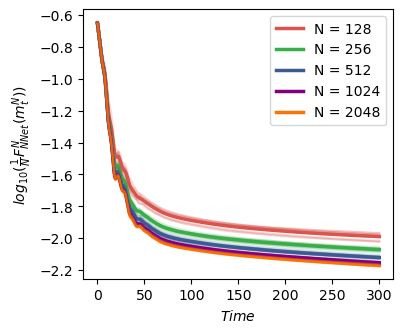

In [16]:
# log 2 loss versus interation numbers, different test var, restore the test info at first

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

# test_var = 'particle_num'
# try:
#     print(test_values)
# except:
#     test_values = [32,64,128,256,512]

# test_var = 'momentum'
# test_values = [True, False]
# lr = 0.01
# test_values = [32,64,128,256,512,1024,2048]

test_var = 'particle_num'
# test_values = [32,64,128,256,512,1024]

log_wise_step = False
log_wise_loss = True
minus_minimum = False
time_xaxis = True

# colors = sns.color_palette("Paired")[1:len(test_values)+1]
colors = [sns.xkcd_rgb['pale red'],sns.xkcd_rgb['medium green'], sns.xkcd_rgb['denim blue'],'purple',sns.xkcd_rgb['orange'],'yellow','black','brown','C1']

plot_idx = 0

fig = plt.figure(figsize=(4,3.5))

if plot_idx == 0:
    ax1 = fig.add_subplot(111)
    ax2 = None
else:
    ax1 = None
    ax2 = fig.add_subplot(111)

axs = [ax1,ax2]
labels = ['\\frac{1}{N}F_{NNet}^N(m_t^N)', '\\frac{1}{N}F_{NNet}^N(m_t^N) + \\frac{1}{N}F_{Ext}^N(m_t^N)']
losses_set = [result_trainloss_set,result_L2_trainloss_set]
disvisible_index = []

for idx, losses in enumerate(losses_set):
    if idx != plot_idx:
        continue
        
    ax = axs[idx]
    eps = 1e-4
    smooth_window_size = 300

    for idx_ in range(len(test_values)):
        if idx_ in disvisible_index:
            continue
        I = np.array(losses[idx_]).shape[-1]
        obser_end = int(I * 1) 
        # obser_end = 200
        
        xplot_set = np.arange(I) if log_wise_loss else np.arange(I-1)
    
        globals()[test_var] = test_values[idx_]
        
        if time_xaxis == False:
            lr = 1

        xplot_set = np.log2(np.arange(1,I+1)) if log_wise_step else np.arange(I)

        for pending_list in losses[idx_]:

            yplot_set = smooth_loss(pending_list, window_size  = smooth_window_size)
            yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)
            
            ax.plot(xplot_set[:obser_end]*lr,yplot_set[:obser_end],c=colors[idx_],alpha=0.2,zorder = 1)
        
        yplot_set = np.mean(losses[idx_],axis=0)
        yplot_set = smooth_loss(yplot_set, window_size  = smooth_window_size)
        yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)

        ax.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth = 2.5,
                 zorder = -idx_,c=colors[idx_],label='N = %d'%(test_values[idx_]))
        
        
    ax.legend(loc = 'upper right',ncol=1)
#     ax.set_ylim(-2,-1)
    ax.set_xlabel('$log_{10} (Step)$') if log_wise_step else plt.xlabel('$Time$')
    ax.set_ylabel('$log_{10} (%s)$'%(labels[idx])) 
    
plt.savefig('MNIST_paths.png', bbox_inches='tight')
plt.show()



## momentum test

In [17]:
# # log 2 loss versus interation numbers, different test var, restore the test info at first

# # test_var = 'c_cutoff'
# # test_values = [1,2,5,10,20]

# # test_var = 'particle_num'
# # try:
# #     print(test_values)
# # except:
# #     test_values = [32,64,128,256,512]

# test_var = 'momentum'
# test_values = [True, False]
# lr = 0.01
# # test_values = [32,64,128,256,512,1024,2048]

# log_wise_step = False
# log_wise_loss = True
# minus_minimum = False
# time_xaxis = True

# # colors = sns.color_palette("Paired")[1:len(test_values)+1]
# colors = ['C0','C3']

# fig = plt.figure(figsize=(4,3.5))
# ax1 = fig.add_subplot(111)
# # ax2 = fig.add_subplot(122)

# axs = [ax1,]
# labels = ['train\ loss', 'L2\ regularized\ train\ loss']
# disvisible_index = [] # [2,4]
# labels = ['Underdamped Langevin','Overdamped Langevin']

# for idx, losses in enumerate([result_trainloss_set]):
    
#     ax = axs[idx]

#     eps = 1e-4
#     smooth_window_size = 1

#     axins = inset_axes(ax, width="40%", height="30%",loc='lower left',
#            bbox_to_anchor=(0.5, 0.45, 0.78, 0.8),
#            bbox_transform=ax.transAxes)

#     axins.set_xlim(0, 50)
#     axins.set_ylim(-2.3, -1.3)

#     for idx_ in range(len(test_values)):
#         if idx_ in disvisible_index:
#             continue
#         I = np.array(losses[idx_]).shape[-1]
#         obser_end = int(I * 1) 
#         # obser_end = 200
        
#         xplot_set = np.arange(I) if log_wise_loss else np.arange(I-1)
    
#         globals()[test_var] = test_values[idx_]
        
#         if time_xaxis == False:
#             lr = 1

#         xplot_set = np.log2(np.arange(1,I+1)) if log_wise_step else np.arange(I)

#         for pending_list in losses[idx_]:

#             yplot_set = smooth_loss(pending_list, window_size  = smooth_window_size)
#             yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)
            
#             ax.plot(xplot_set[:obser_end]*lr,yplot_set[:obser_end],c=colors[idx_],alpha=0.05,zorder = 1)
#             axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],c=colors[idx_],linewidth=2.5)
        
#         yplot_set = np.mean(losses[idx_],axis=0)
#         yplot_set = smooth_loss(yplot_set, window_size  = smooth_window_size)
#         yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)

#         ax.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth = 2.5,
#                  zorder = -idx_,c=colors[idx_],label=labels[idx_])
        
        
#         axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],c=colors[idx_],linewidth=2.5)
    
#     mark_inset(ax, axins,loc1=3, loc2=1, fc="none", ec='k', lw=1,linestyle='--',alpha=0.8)
#     ax.legend(loc = 'upper right',ncol=1)
# #     ax.set_ylim(-2,-1)
#     ax.set_xlabel('$log_{10} (Step)$') if log_wise_step else ax.set_xlabel('$Step$',fontsize =12)
#     ax.set_ylabel('$log_{10} (\\frac{1}{N} F_{NNet})$',fontsize=12) 
    
# plt.savefig('Compared_to_GD.png', bbox_inches='tight')
# plt.show()



## Fitting

In [18]:
from sklearn import linear_model

trained_losses = []
L2_trained_losses = []

for idx, test_vulue in enumerate(test_values):
    trained_losses_current = []
    L2_trained_losses_current = []
    
    for test_number in range(len(result_trainloss_set[idx])):
        trained_losses_current.append(np.mean(result_trainloss_set[idx][test_number][-500:]))
        L2_trained_losses_current.append(np.mean(result_L2_trainloss_set[idx][test_number][-500:]))
        
    trained_losses.append(trained_losses_current)
    L2_trained_losses.append(L2_trained_losses_current)
    


In [52]:
# trained_losses = trained_losses[1:]
# # L2_trained_losses = L2_trained_losses[1:]

## Fixed alpha regression

In [19]:
test_time_per_objective = len(trained_losses_current)
# try:
#     print(test_values)
# except:
#     test_values = [32,64,128,256,512]

test_values = [128,256,512,1024,2048]
test_values = np.array(test_values)
all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
trained_losses = np.array(trained_losses)
L2_trained_losses =  np.array(L2_trained_losses)

model = linear_model.LinearRegression()
alpha = -1.

model.fit(all_data.reshape(-1,1)**(alpha), trained_losses.reshape(-1))
w = model.coef_[0]
b = model.intercept_

model = linear_model.LinearRegression()
alpha_l2 = -1.
          
model.fit(all_data.reshape(-1,1)**(alpha_l2), L2_trained_losses.reshape(-1))
w_l2 = model.coef_[0]
b_l2 = model.intercept_


## 可视化模组1

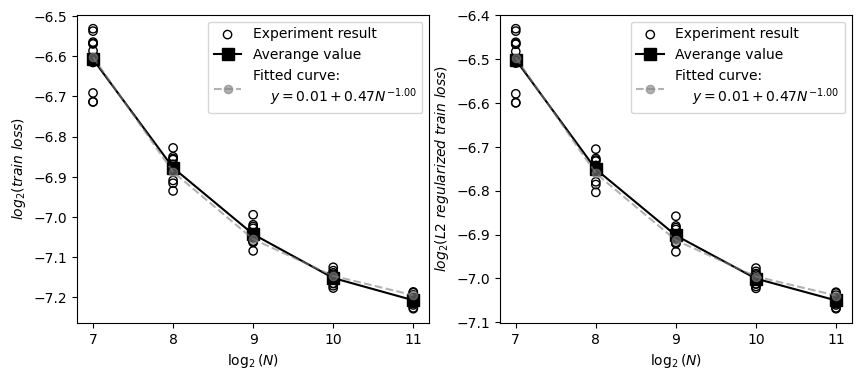

In [20]:
# log 2 terminal loss versus different test var

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
ws = [w, w_l2]
bs = [b, b_l2]
alphas = [alpha, alpha_l2]
logwise_loss = True


for idx, trained_losses_data in enumerate([trained_losses, L2_trained_losses]):
    ax = axs[idx]
    w_plot = ws[idx]
    b_plot = bs[idx]
    alpha_plot = alphas[idx]
    
    avg_trained_loss_vec = np.mean(trained_losses_data,axis=1)

    all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
    
    xplot_all = np.log2(all_data.copy()) if logwise_loss else all_data.copy()
    xplot = np.log2(test_values.reshape(-1).copy()) if logwise_loss else test_values.reshape(-1).copy()
    yplot_all = np.log2(trained_losses_data.reshape(-1).copy()) if logwise_loss else trained_losses_data.reshape(-1).copy()
    yplot =  np.log2(avg_trained_loss_vec.copy())if logwise_loss else avg_trained_loss_vec.copy()
    yplot_predict = np.log2(b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)) if logwise_loss else b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)
    
    ax.scatter(xplot_all,yplot_all,color='none',marker='o',edgecolors='k',linewidths=1,label='Experiment result')
    ax.plot(xplot,yplot,c='k',marker='s',markersize=8,label='Averange value')
    ax.plot(xplot, yplot_predict,'--', marker='o', c= 'grey', label='Fitted curve: \n    $y= %.2f + %.2f N^{%.2f}$'%(b_plot,w_plot,alpha_plot),alpha=0.6)

    ax.legend()
    
    if logwise_loss:
        ax.set_xlabel('$\log_2 (N)$')
        ax.set_ylabel('$log_2 (%s)$'%(labels[idx])) 
    else:
        ax.set_xlabel('$N$')
        ax.set_ylabel('$%s$'%(labels[idx])) 
        
plt.savefig('loss.png', bbox_inches='tight')
plt.show()


## 可视化模组2

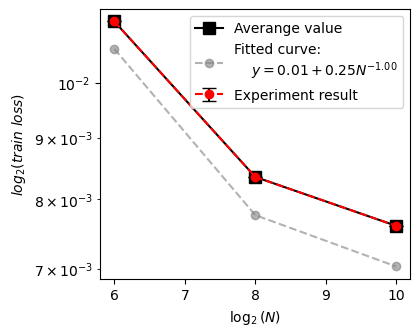

In [38]:
# log 2 terminal loss versus different test var

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(111)

axs = [ax1]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
ws = [w, w_l2]
bs = [b, b_l2]
alphas = [alpha, alpha_l2]
logwise_loss = True


for idx, trained_losses_data in enumerate([L2_trained_losses]):
    ax = axs[idx]
    w_plot = ws[idx]
    b_plot = bs[idx]
    alpha_plot = alphas[idx]
    
    avg_trained_loss_vec = np.mean(trained_losses_data,axis=1)
    std_trained_loss_vec = np.std(trained_losses_data,axis=1)

    all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
    
    xplot = np.log2(test_values.reshape(-1).copy() )
    yplot =  avg_trained_loss_vec.copy()
    yplot_predict = b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)
    
    ax.errorbar(xplot,yplot,std_trained_loss_vec.std(),color='red', ls='--', marker='o', capsize=5, capthick=1, ecolor='black',label='Experiment result')
    ax.plot(xplot,yplot,c='k',marker='s',markersize=8,label='Averange value')
    ax.plot(xplot, yplot_predict,'--', marker='o', c= 'grey', label='Fitted curve: \n    $y= %.2f + %.2f N^{%.2f}$'%(b_plot,w_plot,alpha_plot),alpha=0.6)
    
    ax.set_yscale('log')
#     ax.set_ylim(0.01,0.4)
    ax.legend()
    
    if logwise_loss:
        ax.set_xlabel('$\log_2 (N)$')
        ax.set_ylabel('$log_2 (%s)$'%(labels[idx])) 
    else:
        ax.set_xlabel('$N$')
        ax.set_ylabel('$%s$'%(labels[idx])) 
        
plt.savefig('loss.png', bbox_inches='tight')
plt.show()


In [19]:
std_trained_loss_vec

array([0.07066971, 0.04019733, 0.00739608, 0.01239414, 0.00822539])

In [69]:
particle_num = 128
criterion = nn.MSELoss()
Xai = []

for _ in tqdm(range(1000)):
    net = Net(N=particle_num,cut_off=None).to(device)
    output = net(data)
    loss = criterion(output, target_onehot.float())
    Xai.append(loss.item())
np.mean(Xai)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.56it/s]


22561.98012841797

In [64]:
particle_num = 512
net = Net(N=particle_num,cut_off=cut_off).to(device)
x = torch.ones([28,28]).cuda()
net.fc1(x.view(-1)).mean(),net.fc1(x.view(-1)).std()

(tensor(1.6088, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(27.4478, device='cuda:0', grad_fn=<StdBackward0>))

In [51]:
x = torch.normal(0,4,size = [200])
x.var()

tensor(15.9758)

In [23]:
net.fc2(net.fc1(x.view(-1))).item()

RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [66]:
x = torch.ones([28,28]).cuda()

particle_num = 256
criterion = nn.MSELoss()
Xai = []

for _ in tqdm(range(1000)):
    net = Net(N=particle_num,cut_off=None).to(device)
    Xai.append(net.fc2(net.fc1(x.view(-1)))[0].item()/particle_num)
np.mean(Xai)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.07it/s]


0.05794675201177597

In [20]:
target_onehot.shape

torch.Size([11760, 2])

In [82]:
np.mean(Xai)

19.45249426622391

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

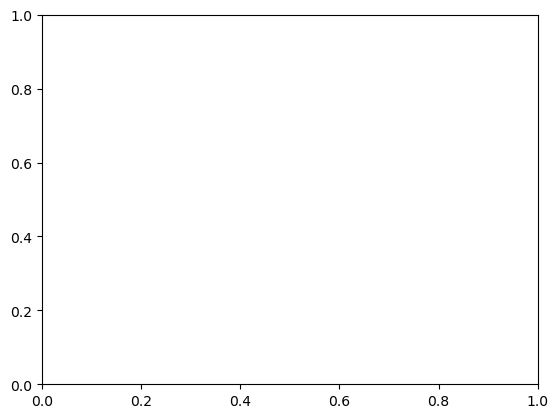

In [74]:
plt.hist(net.fc1.weight)

# CIFAR 10 deployment

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10('../data', train=True, transform = transform, download=True)
test_dataset =  datasets.CIFAR10('../data', train=False,  transform = transform,)

Files already downloaded and verified


In [4]:
# Filter the train dataset to extract images with labels 4 and 6
train_label_4_idx = torch.Tensor(train_dataset.targets) == 4
train_label_6_idx = torch.Tensor(train_dataset.targets) == 6
train_selected_idx = train_label_4_idx | train_label_6_idx

train_selected_images = train_dataset.data[list(train_selected_idx)]
train_selected_labels = np.array(train_dataset.targets)[list(train_selected_idx)]

# Relabel the train images with labels 4 as 0 and labels 6 as 1
train_selected_labels = np.where(train_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the train set
train_dataset = TensorDataset(torch.Tensor(train_selected_images), torch.Tensor(train_selected_labels))

# Filter the test dataset to extract images with labels 4 and 6
test_label_4_idx = torch.Tensor(test_dataset.targets) == 4
test_label_6_idx = torch.Tensor(test_dataset.targets) == 6
test_selected_idx = test_label_4_idx | test_label_6_idx

test_selected_images = test_dataset.data[test_selected_idx]
test_selected_labels = np.array(test_dataset.targets)[test_selected_idx]

# Relabel the test images with labels 4 as 0 and labels 6 as 1
test_selected_labels = np.where(test_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the test set
test_dataset = TensorDataset(torch.Tensor(test_selected_images), torch.Tensor(test_selected_labels))

# transform=transforms.Compose([
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])

## Freed alpha fit

In [14]:
from scipy.optimize import minimize


def loss(param):
    C_1 = param[0]
    C_2 = param[1]
    alpha = param[2]
    return np.mean((L2_trained_losses.reshape(-1) - C_1 - C_2 * all_data ** (alpha) )**2)

method = 'BFGS'
result = minimize(loss, x0=[0,0,0], method = method)
print(result)

b_l2, w_l2, alpha_l2 =  result.x

AttributeError: 'list' object has no attribute 'reshape'